In [2]:
import torch

num_gpus = torch.cuda.device_count()

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No GPU available. Please check your system.")


Number of available GPUs: 1
GPU 0: NVIDIA L4


In [1]:
import os
import torch
from tqdm import tqdm

def load_tensors_from_folders(master_folder):
    tensors = []
    
    # for class_folder in os.listdir(master_folder):
    #     class_folder_path = os.path.join(master_folder, class_folder)
        
        # if os.path.isdir(class_folder_path):
    for file in tqdm(os.listdir(master_folder)):
        if file.endswith('.pt'):
            tensor_path = os.path.join(master_folder, file)
            tensor = torch.load(tensor_path)
            tensors.append(tensor)

    return tensors

def calculate_mean_and_std(tensors):
    # Concatenate tensors along the first dimension (usually the batch dimension)
    concatenated_tensors = torch.cat(tensors, dim=0)

    # Calculate the mean and standard deviation
    mean = torch.mean(concatenated_tensors)
    std = torch.std(concatenated_tensors)
    min_value = torch.min(concatenated_tensors)
    max_value = torch.max(concatenated_tensors)

    return mean, std, min_value, max_value

def min_max_scale(value, min_value, max_value):
    scaled_value = (value - min_value) / (max_value - min_value)
    return scaled_value

tensors = load_tensors_from_folders(master_folder='./datasets/audioset_train_mel_split')
mean, std, min, max = calculate_mean_and_std(tensors)
scaled_mean = min_max_scale(mean, min, max)
scaled_std = min_max_scale(std, min, max)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")
print(f"Min: {min}")
print(f"Max: {max}")
print(f"Scaled mean: {scaled_mean}")
print(f"Scaled standard deviation: {scaled_std}")




100%|██████████| 33192/33192 [00:17<00:00, 1850.61it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1001 but got size 921 for tensor number 4 in the list.

In [2]:
import torch

x = torch.load('./gtzan_train_mel_split/blues/blues.00017_part2.pt')

print(x.shape)

torch.Size([1, 64, 1001])


In [1]:
from conv_wav_mel import convert_wav_mel

convert = convert_wav_mel(target_sample_rate=16000, target_sec=10)

root_dir = './datasets/train_wav/'
save_dir = './datasets/audioset_train_mel_split/'

convert.convert(root_dir=root_dir, save_dir=save_dir)


root_dir = './datasets/gtzan_train_wav_split/'
save_dir = './datasets/gtzan_train_mel_split/'

convert.convert(root_dir=root_dir, save_dir=save_dir)

root_dir = './datasets/gtzan_val_wav_split/'
save_dir = './datasets/gtzan_val_mel_split/'

convert.convert(root_dir=root_dir, save_dir=save_dir)

/home/vebjo/.local/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
 75%|███████▍  | 14720/19644 [05:29<01:45, 46.62it/s]

Skipping empty waveform in file: SBvohbf5B2M.wav


 97%|█████████▋| 19117/19644 [07:10<00:12, 43.87it/s]

Skipping empty waveform in file: kKf9OprN9nw.wav


100%|██████████| 60/60 [00:00<00:00, 76.28it/s]


In [1]:
from dataset import split_wav_files

src_folder = './gtzan_val_wav/'
dest_folder = './gtzan_val_wav_split'
time_length = 10  # Length of the segment in seconds
hop_length =  10 # Hop length in seconds

split_wav_files(src_folder, dest_folder, time_length, hop_length)

src_folder = './genres_original/'
dest_folder = './gtzan_train_wav_split'

split_wav_files(src_folder, dest_folder, time_length, hop_length)

# src_folder = './train_wav/'
# dest_folder = './audioset_train_wav_split'

# split_wav_files(src_folder, dest_folder, time_length, hop_length)

0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 192.82it/s]
0it [00:00, ?it/s]
100%|██████████| 80/80 [00:00<00:00, 165.73it/s]


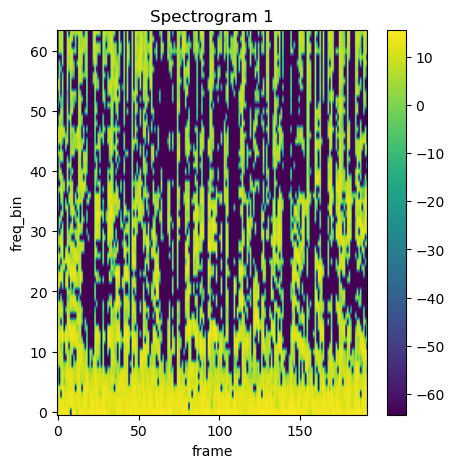

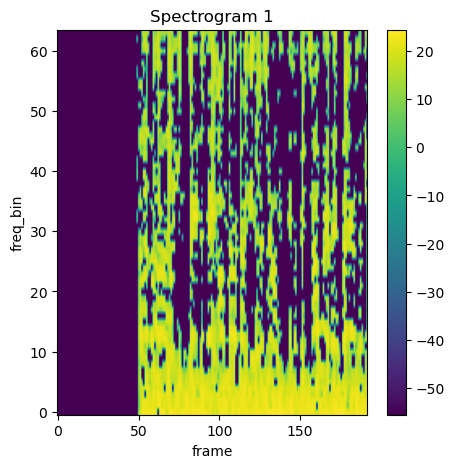

In [3]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from dataset import AudioDataset
from augmentations import aug_pipeline, mel_aug, RandomCropWidth
from torch.utils.data import DataLoader

import torchvision.transforms as transforms

def plot_spectrogram(specs, titles=None, ylabel="freq_bin", aspect="auto", xmax=None):
    n_images = specs.shape[0]
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 5, 5))
    
    if n_images == 1:
        axes = [axes]  # Handle the case when there's only one plot
    
    for i, ax in enumerate(axes):
        mel_spectrogram = specs[i].cpu().numpy().squeeze()  # Remove the batch dimension
        title = titles[i] if titles else f'Spectrogram {i + 1}'
        
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel("frame")
        im = ax.imshow(librosa.power_to_db(mel_spectrogram), origin="lower", aspect=aspect)
        
        if xmax:
            ax.set_xlim((0, xmax))

        fig.colorbar(im, ax=ax)  # Create a separate colorbar for each plot
    
    plt.show(block=False)

root_dir = './gtzan_train_mel_split/'
batch_size = 1

mean = 0.0008
std = 0.0060
transform = transforms.Compose([
    # transforms.Normalize([mean], [std])
    # RandomCropWidth(target_width=96)

    ])

dataset = AudioDataset(root_dir, target_sample_rate=16000, unit_sec=0.95, transform=transform)
audio_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

# transform_mel = mel_aug()
transform = aug_pipeline()

data_iter = iter(audio_dataloader)
audio, _ = next(data_iter)
# mel_audio = transform_mel(audio) 
aug_audio = transform(audio)

plot_spectrogram(audio)
plot_spectrogram(aug_audio)


In [1]:
from conv_wav_mel import create_test_set

test_folder = './gtzan_val_wav'
src_folder = './genres_original/'

create_test_set(test_folder=test_folder, src_folder=src_folder)